In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd() / "notebooks"))  # so we can import _utils from notebooks/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from _utils import get_data_dir

DATA_DIR = get_data_dir()
DATA_DIR


WindowsPath('C:/Users/AdamR/OneDrive/UCSB/VIU/HonorsThesis/data')

In [3]:
from pyexpat import model
import pandas as pd
from pathlib import Path
from _utils import get_data_dir

ROOT = get_data_dir()
conds = ["50_50", "80_20", "100_0"]
dfs = []

def load_decisions(path, cond, model):
    df = pd.read_csv(path)
    df["stimID"] = df["image_id"]
    df["condition"] = cond
    df["participantID"] = model
    df["response"] = (
        df["GPT_response"].astype(str).str.strip().str.lower()
        .replace({"true": "present", "false": "absent"})
    )
    df["decision"] = df["response"].map({"present": 1, "absent": 0})
    return df[[
        "stimID","condition","side_selected","cue_points","line1_angle",
        "line2_angle","valid_cue","TP","response","participantID","decision"
    ]]

def parse_gemini(resp):
    a1, a2, dec = [p.strip() for p in str(resp).split(",")]
    return float(a1), float(a2), dec.lower()

for cond in conds:
    base = ROOT / cond

    # all decision models
    for f in (base / "decisions").glob("*.csv"):
        dfs.append(load_decisions(f, cond, f.stem))

    # gemini angle-estimation model
    g = pd.read_csv(base / "angle_estimations" / "gemini-2.5-pro.csv")
    g[["est1", "est2", "response"]] = pd.DataFrame(
        g["GPT_response"].apply(parse_gemini).tolist(), index=g.index
    )
    g["stimID"] = g["image_id"]
    g["condition"] = cond
    g["participantID"] = "gemini-2.5-pro"
    g["decision"] = g["response"].map({"present": 1, "absent": 0})
    dfs.append(g[[
        "stimID","condition","side_selected","cue_points","line1_angle",
        "line2_angle","valid_cue","TP","response","participantID","decision"
    ]])

model_master = pd.concat(dfs, ignore_index=True)
display(model_master)


,stimID,condition,side_selected,cue_points,line1_angle,line2_angle,valid_cue,TP,response,participantID,decision
0,100,50_50,1,2,14.314827,1.921956,False,True,present,0responses_claude-3-5-haiku-20241022,1
1,845,50_50,1,2,15.054317,4.222230,False,True,absent,0responses_claude-3-5-haiku-20241022,0
2,245,50_50,1,1,14.314827,6.508956,True,True,absent,0responses_claude-3-5-haiku-20241022,0
3,72,50_50,2,2,8.775056,15.054317,True,True,present,0responses_claude-3-5-haiku-20241022,1
4,469,50_50,2,2,4.222230,19.885165,True,True,absent,0responses_claude-3-5-haiku-20241022,0
...,...,...,...,...,...,...,...,...,...,...,...
38995,698,100_0,1,1,11.159944,6.508956,True,False,present,gemini-2.5-pro,1
38996,910,100_0,1,2,9.651833,4.986334,False,False,absent,gemini-2.5-pro,0
38997,880,100_0,2,2,4.222230,8.775056,True,False,absent,gemini-2.5-pro,0
38998,53,100_0,2,2,4.986334,11.908300,True,False,present,gemini-2.5-pro,1


In [ ]:
#All Models Metrics Table

df = model_master.copy()

def compute_sdt(df):
    hits = ((df["TP"]==1) & (df["decision"]==1)).mean()
    fas  = ((df["TP"]==0) & (df["decision"]==1)).mean()

    # Add tiny epsilon to avoid inf in z-scores
    eps = 1e-6
    dprime = norm.ppf(min(max(hits, eps), 1-eps)) - norm.ppf(min(max(fas, eps), 1-eps))
    crit   = -0.5*( norm.ppf(min(max(hits, eps), 1-eps)) + 
                    norm.ppf(min(max( fas, eps), 1-eps)) )
    return hits, fas, dprime, crit

rows = []
for (model, cond), g in df.groupby(["participantID","condition"]):
    acc = (g["decision"] == g["TP"]).mean()
    hits, fas, dp, c = compute_sdt(g)
    rows.append({
        "participantID": model,
        "condition": cond,
        "n_trials": len(g),
        "accuracy": acc,
        "hit_rate": hits,
        "fa_rate": fas,
        "dprime": dp,
        "criterion": c
    })

AMM = pd.DataFrame(rows)
AMM

,participantID,condition,n_trials,accuracy,hit_rate,fa_rate,dprime,criterion
0,0responses_claude-3-5-haiku-20241022,100_0,1000,0.486,0.182,0.196,-0.051774,0.881883
1,0responses_claude-3-5-haiku-20241022,50_50,1000,0.460,0.178,0.218,-0.144048,0.850990
2,0responses_claude-3-5-haiku-20241022,80_20,1000,0.490,0.176,0.186,-0.037984,0.911725
3,0responses_claude-3-7-sonnet-20250219,100_0,1000,0.490,0.238,0.248,-0.031954,0.696774
4,0responses_claude-3-7-sonnet-20250219,50_50,1000,0.498,0.211,0.213,-0.006901,0.799506
5,0responses_claude-3-7-sonnet-20250219,80_20,1000,0.483,0.235,0.252,-0.054270,0.695344
6,0responses_claude-opus-4-20250514,100_0,1000,0.473,0.179,0.206,-0.098804,0.869781
7,0responses_claude-opus-4-20250514,50_50,1000,0.479,0.170,0.191,-0.079948,0.914191
8,0responses_claude-opus-4-20250514,80_20,1000,0.477,0.180,0.203,-0.084412,0.873159
9,0responses_claude-sonnet-4-20250514,100_0,1000,0.486,0.331,0.345,-0.038298,0.418004


In [7]:
#hit rate vs invalid HR Table
df = model_master.copy()

# --- 1. Compute hit indicator for TP=1 trials ---
hits = (
    df[df["TP"] == True]
      .assign(hit=lambda d: (d["decision"] == 1).astype(int))
      .groupby(["participantID", "condition", "valid_cue"], as_index=False)["hit"]
      .mean()
)

# --- 2. Pivot valid vs invalid hit rates ---
hr_table = (
    hits.pivot(index=["participantID", "condition"],
               columns="valid_cue", values="hit")
        .rename(columns={0: "hr_invalid", 1: "hr_valid"})
        .reset_index()
)

# --- 3. Add ΔHR (cue advantage) ---
hr_table["delta_hr"] = hr_table["hr_valid"] - hr_table["hr_invalid"]

hr_table


valid_cue,participantID,condition,hr_invalid,hr_valid,delta_hr
0,0responses_claude-3-5-haiku-20241022,100_0,NaN,0.364000,NaN
1,0responses_claude-3-5-haiku-20241022,50_50,0.337398,0.374016,0.036617
2,0responses_claude-3-5-haiku-20241022,80_20,0.280899,0.367397,0.086498
3,0responses_claude-3-7-sonnet-20250219,100_0,NaN,0.476000,NaN
4,0responses_claude-3-7-sonnet-20250219,50_50,0.443089,0.401575,-0.041515
5,0responses_claude-3-7-sonnet-20250219,80_20,0.404494,0.484185,0.079691
6,0responses_claude-opus-4-20250514,100_0,NaN,0.358000,NaN
7,0responses_claude-opus-4-20250514,50_50,0.333333,0.346457,0.013123
8,0responses_claude-opus-4-20250514,80_20,0.314607,0.369830,0.055223
9,0responses_claude-sonnet-4-20250514,100_0,NaN,0.662000,NaN


C:\Users\AdamR\AppData\Local\Temp\ipykernel_6996\2997988913.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hr_plot["below_diag"] = hr_plot["hr_valid"] < hr_plot["hr_invalid"]


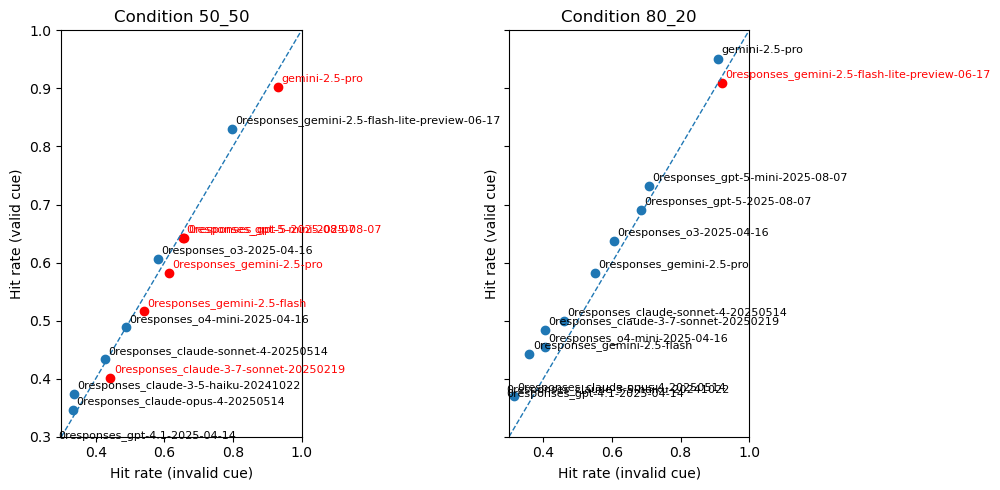

Models below diagonal (valid HR < invalid HR) in 50_50 or 80_20:


valid_cue,participantID,condition,hr_invalid,hr_valid
4,0responses_claude-3-7-sonnet-20250219,50_50,0.443089,0.401575
13,0responses_gemini-2.5-flash,50_50,0.540650,0.515748
17,0responses_gemini-2.5-flash-lite-preview-06-17,80_20,0.921348,0.909976
19,0responses_gemini-2.5-pro,50_50,0.613821,0.582677
25,0responses_gpt-5-2025-08-07,50_50,0.658537,0.641732
28,0responses_gpt-5-mini-2025-08-07,50_50,0.654472,0.641732
37,gemini-2.5-pro,50_50,0.930894,0.901575


In [ ]:
#HR Plot
df = model_master.copy()

# --- 1. Hit rate by valid_cue for each model × condition ---
hits = (
    df[df["TP"] == 1]
      .assign(hit=lambda d: (d["decision"] == 1).astype(int))
      .groupby(["participantID", "condition", "valid_cue"], as_index=False)["hit"]
      .mean()
)

# Pivot to valid vs invalid cue hit rates
hr = (
    hits.pivot(index=["participantID", "condition"],
               columns="valid_cue", values="hit")
        .rename(columns={0: "hr_invalid", 1: "hr_valid"})
        .reset_index()
)

# Only plot 50_50 and 80_20
hr_plot = hr[hr["condition"].isin(["50_50", "80_20"])]

# Identify models below the diagonal
hr_plot["below_diag"] = hr_plot["hr_valid"] < hr_plot["hr_invalid"]

# --- 3. Plot with zoomed axes ---
conds = ["50_50", "80_20"]
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

for ax, cond in zip(axes, conds):
    sub = hr_plot[hr_plot["condition"] == cond]

    # Above/on diagonal
    good = sub[~sub["below_diag"]]
    ax.scatter(good["hr_invalid"], good["hr_valid"])
    for _, row in good.iterrows():
        ax.text(row["hr_invalid"] + 0.01, row["hr_valid"] + 0.01,
                row["participantID"], fontsize=8)

    # Below diagonal (red)
    bad = sub[sub["below_diag"]]
    ax.scatter(bad["hr_invalid"], bad["hr_valid"], color="red")
    for _, row in bad.iterrows():
        ax.text(row["hr_invalid"] + 0.01, row["hr_valid"] + 0.01,
                row["participantID"], fontsize=8, color="red")

    # Diagonal line
    ax.plot([0.3, 1], [0.3, 1], linestyle="--", linewidth=1)

    ax.set_title(f"Condition {cond}")
    ax.set_xlabel("Hit rate (invalid cue)")
    ax.set_ylabel("Hit rate (valid cue)")
    ax.set_xlim(0.3, 1)
    ax.set_ylim(0.3, 1)

plt.tight_layout()
plt.show()

# --- 4. Print bad models ---
bad_models = (
    hr_plot[hr_plot["below_diag"]]
    .sort_values(["participantID", "condition"])
    [["participantID", "condition", "hr_invalid", "hr_valid"]]
)

print("Models below diagonal (valid HR < invalid HR) in 50_50 or 80_20:")
display(bad_models)


In [12]:
#Top 8 Models by Simple Hit Rate and Cue Advantage
df = model_master.copy()

hits = (
    df[df["TP"] == 1]
      .assign(hit=lambda d: (d["decision"] == 1).astype(int))
      .groupby(["participantID", "condition", "valid_cue"], as_index=False)["hit"]
      .mean()
)


hr = (
    hits.pivot(index=["participantID", "condition"],
               columns="valid_cue", values="hit")
        .rename(columns={0: "hr_invalid", 1: "hr_valid"})
        .reset_index()
)


hr = hr[hr["condition"].isin(["50_50", "80_20"])]


hr["delta_hr"] = hr["hr_valid"] - hr["hr_invalid"]


model_hr = (
    hr.groupby("participantID", as_index=False)
      .agg(mean_hr_valid=("hr_valid", "mean"),
           mean_delta_hr=("delta_hr", "mean"))
)


model_hr["score"] = model_hr["mean_hr_valid"] + model_hr["mean_delta_hr"]


best8_simple = model_hr.sort_values("score", ascending=False).head(8)
best8_names = best8_simple["participantID"].tolist()

BMM = model_master[model_master["participantID"].isin(best8_names)].copy()


display(BMM.head())

,stimID,condition,side_selected,cue_points,line1_angle,line2_angle,valid_cue,TP,response,participantID,decision
4000,100,50_50,1,2,14.314827,1.921956,False,True,absent,0responses_gemini-2.5-flash-lite-preview-06-17,0
4001,845,50_50,1,2,15.054317,4.222230,False,True,absent,0responses_gemini-2.5-flash-lite-preview-06-17,0
4002,245,50_50,1,1,14.314827,6.508956,True,True,present,0responses_gemini-2.5-flash-lite-preview-06-17,1
4003,72,50_50,2,2,8.775056,15.054317,True,True,present,0responses_gemini-2.5-flash-lite-preview-06-17,1
4004,469,50_50,2,2,4.222230,19.885165,True,True,absent,0responses_gemini-2.5-flash-lite-preview-06-17,0
